# Module

In [2]:
# 과학계산
import pandas as pd
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
import numpy as np

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score, log_loss

# 기타
import datetime
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 10, 'display.max_columns', 10)

# Rectified Dataset split

In [10]:
train = pd.read_csv('../dataset_processed/train_538132.csv')
val = pd.read_csv('../dataset_processed/validation_179377.csv')
test = pd.read_csv('../dataset_processed/test_179378.csv')

In [ ]:
X_train = train.drop('depvar', axis=1)
y_train = train['depvar']

X_val = val.drop('depvar', axis=1)
y_val = val['depvar']

X_test = test.drop('depvar', axis=1)
y_test = test['depvar']

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

NameError: name 'X_train' is not defined

# Training

In [7]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [8]:
dt_clf.tree_.max_depth

61

# Validation

### X_val에 대한 평가지표 확인

In [9]:
pred_val = dt_clf.predict(X_val)

accuracy = accuracy_score(y_val, pred_val)
precision = precision_score(y_val, pred_val)
recall = recall_score(y_val, pred_val)
conf_matrix = confusion_matrix(y_val, pred_val)
print('\n 정확도: {0}, 정밀도도: {1}, 재현율율: {2}'.format(accuracy, precision, recall))
print(conf_matrix)


 정확도: 0.7320169252468265, 정밀도도: 0.19550511365457984, 재현율율: 0.20973344797936372
[[125209  25093]
 [ 22977   6098]]


### X_val fitting

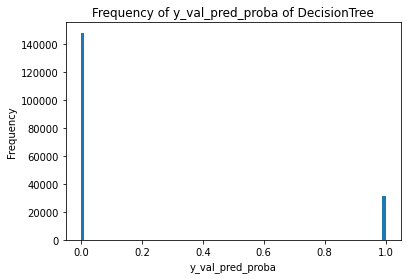

In [10]:
# Predict probabilities for new data

model_name = 'DecisionTree'

y_val_pred_proba = dt_clf.predict_proba(X_val) # 확률로 추정된 X_val의 y_pred

plt.hist(y_val_pred_proba[:,1], bins=100)

plt.xlabel('y_val_pred_proba')
plt.ylabel('Frequency')
plt.title('Frequency of y_val_pred_proba of %s'%(model_name))

plt.savefig("%s_val_pre_proba_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

plt.show() # y_val_pred_proba의 분포 확인

In [11]:
y_val_pred_proba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

### optimal threshold 선정 (threshold에 따른 목적함수 값 비교)

실제 positive = TP + FN

실제 Negative = TN + FP

정밀도: positive로 예측한 것 중에 진짜 positive인 것 -> 양성 예측도

재현율: 실제 positive 중에 맞춘 것 -> 민감도

In [12]:
threshold_list = np.linspace(0.11,0.14,10) # 짝수개 값 (예시 10개)

Threshold에 따른 지표 비교

0, 1 count / confusion_matrix / accuracy, precision, recall, f1 score 

In [13]:
def threshold_func(y_val, y_pred_proba, threshold_list):
    
    n = len(threshold_list)
    
    result_df = pd.DataFrame(index=['1_real','1_pred','0_real','0_pred','tn', 'fp', 'fn', 'tp', 'tn_%', 'fp_%', 'fn_%', 'tp_%', 'Accuracy', 'Precision', 'Recall', 'F1 score'])
    
    fig, axes = plt.subplots(nrows=int(n/2), ncols=2, figsize=(10, 10))
    
    for i in range(len(threshold_list)):
        
        threshold = threshold_list[i]
        
        # make Binarizer(y hat)
        binarizer = Binarizer(threshold = threshold).fit(y_pred_proba[:,1].reshape(-1,1))
        custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))
        
        # count 0, 1 in Binarizer(y hat)
        unique, counts = np.unique(custom_predict, return_counts=True)

        for val, count in zip(unique, counts):
            if len(unique) == 1:
                if val == 1.0:
                    num_0_pred = 0
                    num_1_pred = count
                elif val == 0.0:
                    num_1_pred = 0
                    num_0_pred = count
            if val == 1.0:
                num_1_pred = count
            elif val == 0.0:
                num_0_pred = count

        # count 0, 1 in y hat
        num_0_real = y_val.value_counts()[0]
        num_1_real = y_val.value_counts()[1]
        
        tn, fp, fn, tp = confusion_matrix(y_val, custom_predict).ravel()
        count = [tn, fp, fn, tp]
        tn_, fp_, fn_, tp_ = [round(x/sum(count)*100, 1) for x in count]
        
        accuracy = round((tp+tn)/(tp+tn+fp+fn),4)
        precision = round(tp/(tp+fp),4)
        recall = round(tp/(tp+fn),4)
        f1 = round(2*(precision*recall)/(precision+recall),4)
        
        threshold_tag = round(threshold_list[i], 4)
        
        result_df[threshold_tag] = [num_1_real, num_1_pred, num_0_real, num_0_pred, tn, fp, fn, tp, tn_, fp_, fn_, tp_, accuracy, precision, recall, f1]
        
        labels = ['TN','FP','FN','TP']
        
        # tn, fp, fn, tp 각각의 값을 counts 리스트에 저장
        counts = [tn, fp, fn, tp]

        # 해당하는 subplot에 그래프 그리기
        axes[i//2, i%2].bar(labels, counts)
        axes[i//2, i%2].set_title(threshold_tag)
        axes[i//2, i%2].set_ylabel('Count')

    # 그래프 간격 조절하기
    plt.tight_layout()
    
    plt.savefig("%s_threshold_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

    # 그래프 출력하기
    plt.show()
    
    result_df.to_csv('%s_threshold_%s.csv'%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), index=True)
    
    return result_df

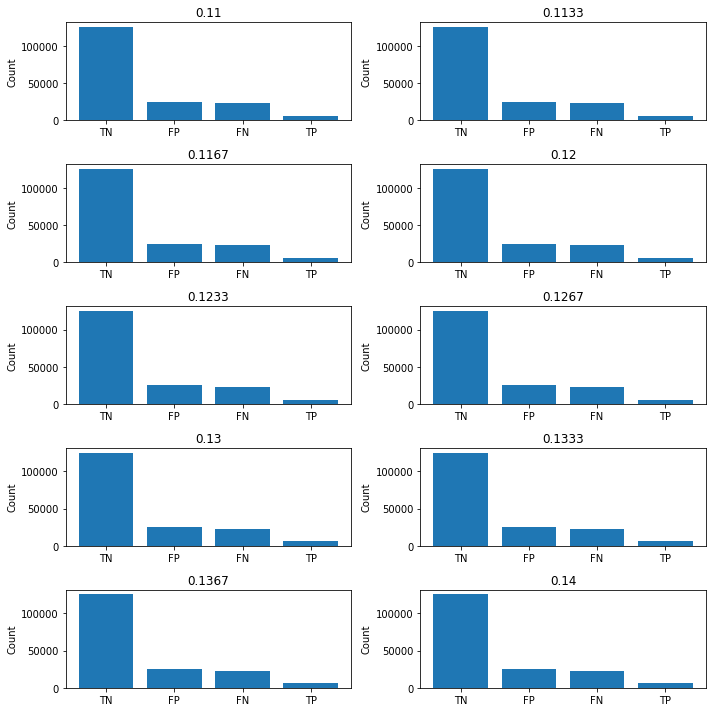

,0.1100,0.1133,0.1167,0.1200,0.1233,0.1267,0.1300,0.1333,0.1367,0.1400
1_real,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000,29075.0000
1_pred,31191.0000,31191.0000,31191.0000,31191.0000,31191.0000,31191.0000,31191.0000,31191.0000,31191.0000,31191.0000
0_real,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000,150302.0000
0_pred,148186.0000,148186.0000,148186.0000,148186.0000,148186.0000,148186.0000,148186.0000,148186.0000,148186.0000,148186.0000
tn,125209.0000,125209.0000,125209.0000,125209.0000,125209.0000,125209.0000,125209.0000,125209.0000,125209.0000,125209.0000
fp,25093.0000,25093.0000,25093.0000,25093.0000,25093.0000,25093.0000,25093.0000,25093.0000,25093.0000,25093.0000
fn,22977.0000,22977.0000,22977.0000,22977.0000,22977.0000,22977.0000,22977.0000,22977.0000,22977.0000,22977.0000
tp,6098.0000,6098.0000,6098.0000,6098.0000,6098.0000,6098.0000,6098.0000,6098.0000,6098.0000,6098.0000
tn_%,69.8000,69.8000,69.8000,69.8000,69.8000,69.8000,69.8000,69.8000,69.8000,69.8000
fp_%,14.0000,14.0000,14.0000,14.0000,14.0000,14.0000,14.0000,14.0000,14.0000,14.0000


In [14]:
threshold_func(y_val, y_val_pred_proba, threshold_list)

Threshold에 따른 목적함수 값 비교

In [15]:
OPT_threshold = None
OPT_expected_loss = None

def objective_func(y_pred_proba, threshold_list):
    
        result_df = pd.DataFrame(index=['1-TPR','FPR','w1_1-TPR','w2_FPR','Expected_loss'])
        
        expected_loss_list = []
        
        for i in range(len(threshold_list)):
            
            threshold = threshold_list[i]
            
            # make Binarizer(y hat)
            binarizer = Binarizer(threshold = threshold).fit(y_pred_proba[:,1].reshape(-1,1))
            custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

            tn, fp, fn, tp = confusion_matrix(y_val, custom_predict).ravel()
            count = [tn, fp, fn, tp]
            
            tpr_1 = fn / (fn + tp)
            fpr = fp / (fp + tn)
            w1 = 0.55
            w2 = 0.45
            
            expected_loss = w1 * tpr_1 + w2 * fpr
            
            expected_loss_list.append(expected_loss)
            
            threshold_tag = round(threshold_list[i], 4)
        
            result_df[threshold_tag] = [tpr_1, fpr, w1*tpr_1, w2*fpr, expected_loss]
            
            if i == 0:
                opt_threshold = threshold
                opt_expected_loss = expected_loss
            else:
                if opt_expected_loss > expected_loss:
                    opt_threshold = threshold
                    opt_expected_loss = expected_loss
                    
#         expected_loss_list = [round(x, 1) for x in expected_loss_list]

        print(opt_threshold)
        print(opt_expected_loss)
        
        plt.plot(threshold_list, expected_loss_list)
        plt.scatter(threshold_list, expected_loss_list)
        
        plt.xlabel('Threshold')
        plt.ylabel('Expected_Loss')
        plt.title('Expected Loss of Thresholds of %s'%(model_name))

        plt.savefig("%s_expected_loss_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')
        
        plt.show()
        
        global OPT_threshold
        OPT_threshold = opt_threshold
        global OPT_expected_loss
        OPT_expected_loss = opt_expected_loss
        
        result_df.to_csv('%s_expected_loss_%s.csv'%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), float_format='%.3f', index=True)
        
        return result_df

0.11
0.5097743464224903


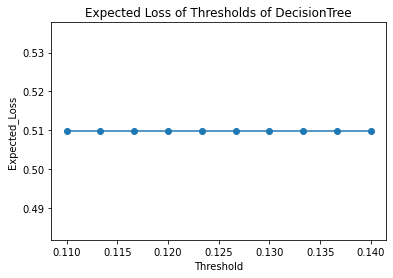

,0.1100,0.1133,0.1167,0.1200,0.1233,0.1267,0.1300,0.1333,0.1367,0.1400
1-TPR,0.790267,0.790267,0.790267,0.790267,0.790267,0.790267,0.790267,0.790267,0.790267,0.790267
FPR,0.166951,0.166951,0.166951,0.166951,0.166951,0.166951,0.166951,0.166951,0.166951,0.166951
w1_1-TPR,0.434647,0.434647,0.434647,0.434647,0.434647,0.434647,0.434647,0.434647,0.434647,0.434647
w2_FPR,0.075128,0.075128,0.075128,0.075128,0.075128,0.075128,0.075128,0.075128,0.075128,0.075128
Expected_loss,0.509774,0.509774,0.509774,0.509774,0.509774,0.509774,0.509774,0.509774,0.509774,0.509774


In [16]:
objective_func(y_val_pred_proba, threshold_list)

# 더 세밀한 범위에서 optimal threshold를 잡고싶으면 한 번 더 다시 실행

In [17]:
OPT_threshold

0.11

histogram에 optimal threshold 표시

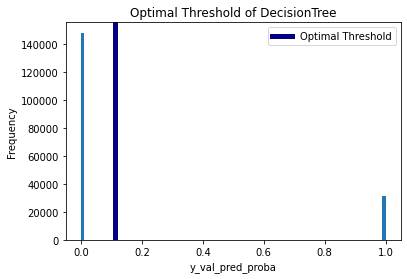

In [18]:
plt.hist(y_val_pred_proba[:,1], bins=100)

plt.axvline(x=OPT_threshold, color='navy', linewidth=5, label='Optimal Threshold')

plt.xlabel('y_val_pred_proba')
plt.ylabel('Frequency')
plt.title('Optimal Threshold of %s'%(model_name))
plt.legend()

plt.savefig("%s_opt_threshold_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

plt.show() # y_val_pred_proba의 분포 확인

# Test 

### X_test fitting

NameError: ignored

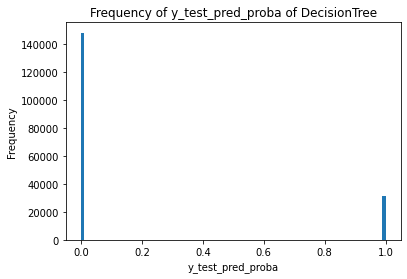

In [ ]:
# Predict probabilities for new data
y_test_pred_proba = dt_clf.predict_proba(X_test) # 확률로 추정된 X_test의 y_pred

plt.hist(y_test_pred_proba[:,1], bins=100)

plt.xlabel('y_test_pred_proba')
plt.ylabel('Frequency')
plt.title('Frequency of y_test_pred_proba of %s'%(model_name))
D
plt.savefig("%s_test_pre_proba_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')

plt.show() # y_test_pred_proba의 분포 확인

### 0, 1 count / confusion_matrix / accuracy, precision, recall, f1 score 

In [ ]:
def test_func(y_test, y_pred_proba, opt_threshold):
        
    # make Binarizer(y hat)
    binarizer = Binarizer(threshold = opt_threshold).fit(y_pred_proba[:,1].reshape(-1,1))
    custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

    # count 0, 1 in Binarizer(y hat)
    unique, counts = np.unique(custom_predict, return_counts=True)

    for val, count in zip(unique, counts):
        if len(unique) == 1:
            if val == 1.0:
                num_0_pred = count
                num_1_pred = 0
            elif val == 0.0:
                num_1_pred = count
                num_0_pred = 0
        if val == 1.0:
            num_0_pred = count
        elif val == 0.0:
            num_1_pred = count

    # count 0, 1 in y hat
    num_1_real = y_test.value_counts()[0]
    num_0_real = y_test.value_counts()[1]

    tn, fp, fn, tp = confusion_matrix(y_test, custom_predict).ravel()
    count = [tn, fp, fn, tp]
    tn_, fp_, fn_, tp_ = [round(x/sum(count)*100, 1) for x in count]

    accuracy = round((tp+tn)/(tp+tn+fp+fn),4)
    precision = round(tp/(tp+fp),4)
    recall = round(tp/(tp+fn),4)
    f1 = round(2*(precision*recall)/(precision+recall),4)
    
    result_df = pd.DataFrame(index=['1_real','1_pred','0_real','0_pred','tn', 'fp', 'fn', 'tp', 'tn_%', 'fp_%', 'fn_%', 'tp_%', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

    result_df['result'] = [num_1_real, num_1_pred, num_0_real, num_0_pred, tn, fp, fn, tp, tn_, fp_, fn_, tp_, accuracy, precision, recall, f1]

    labels = ['TN','FP','FN','TP']


    # 혼동 행렬 시각화
    labels = ['Positive', 'Negative']
    cm = [[tp, fn], [fp, tn]]

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Acutual Class')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('%s Confusion Matrix'%(model_name))
    
    ax.text(0.45, 1.40, 'FP', fontsize=12, color='red')
    ax.text(1.45, 1.40, 'TN', fontsize=12, color='red')
    ax.text(0.45, 0.40, 'TP', fontsize=12, color='red')
    ax.text(1.45, 0.40, 'FN', fontsize=12, color='red')
    
    plt.savefig("%s_Confusion_Matrix_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')
    plt.show()
    
    result_df.T.to_csv('%s_test.csv'%(model_name), index=True)

    return result_df.T

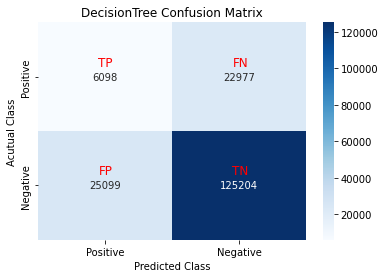

,1_real,1_pred,0_real,0_pred,tn,fp,fn,tp,tn_%,fp_%,fn_%,tp_%,Accuracy,Precision,Recall,F1 score
result,150303.0,148181.0,29075.0,31197.0,125204.0,25099.0,22977.0,6098.0,69.8,14.0,12.8,3.4,0.732,0.1955,0.2097,0.2024


In [ ]:
test_func(y_test, y_test_pred_proba, OPT_threshold)

### Objective Function

In [ ]:
def test_objective_func(y_test, y_pred_proba, threshold):
    
        result_df = pd.DataFrame(index=['1-TPR','FPR','w1_1-TPR','w2_FPR','Expected_loss'])
            
        # make Binarizer(y hat)
        binarizer = Binarizer(threshold = threshold).fit(y_pred_proba[:,1].reshape(-1,1))
        custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

        tn, fp, fn, tp = confusion_matrix(y_test, custom_predict).ravel()
        count = [tn, fp, fn, tp]

        tpr_1 = fn / (fn + tp)
        fpr = fp / (fp + tn)
        w1 = 0.55
        w2 = 0.45

        expected_loss = w1 * tpr_1 + w2 * fpr

        result_df[threshold] = [tpr_1, fpr, w1*tpr_1, w2*fpr, expected_loss]

        print(expected_loss)
        
        result_df.T.to_csv('%s_test_expected_loss_%s.csv'%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), float_format='%.6f', index=True)
        
        return result_df

In [ ]:
test_objective_func(y_test, y_test_pred_proba, OPT_threshold)

0.5097918102938515


,0.11
1-TPR,0.790267
FPR,0.166989
w1_1-TPR,0.434647
w2_FPR,0.075145
Expected_loss,0.509792


### ROC curve

거짓 양성 비율(FPR, 1-TNR:1-특이도)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선

정밀도: positive로 예측한 것 중에 진짜 positive인 것 -> 양성 예측도

재현율: 실제 positive 중에 맞춘 것 -> 민감도

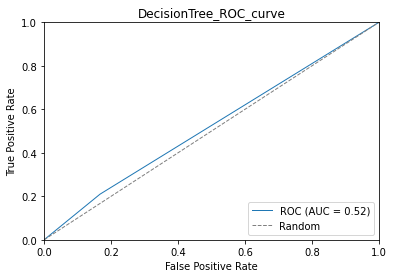

In [ ]:
# Generate ROC curve and AUC score for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s_ROC_curve'%(model_name))
plt.legend(loc='lower right')

plt.savefig("%s_ROC_curve_%s.png"%(model_name, datetime.datetime.now().strftime("%m%d%H%M%S")), dpi=300, bbox_inches='tight')
plt.show()

In [19]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names=['0','1'], feature_names=X_train.columns, impurity=True, filled=True)

In [ ]:
import graphviz
with open("tree.dot") as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
graph = graphviz.Source(dot_graph)
graph.render(filename='under', directory='./', format='png')

# Test 

### X_test fitting

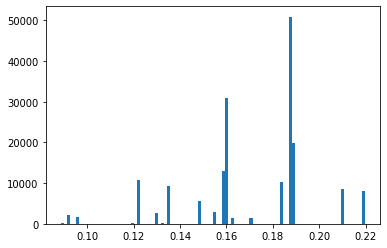

In [ ]:
# Predict probabilities for new data
y_test_pred_proba = best_estimator.predict_proba(X_test) # 확률로 추정된 X_test의 y_pred

plt.hist(y_test_pred_proba[:,1], bins=100)
plt.show() # y_test_pred_proba의 분포 확인

### 0, 1 count / confusion_matrix / accuracy, precision, recall, f1 score 

In [ ]:
def test_func(y_test, y_pred_proba, opt_threshold):
        
    # make Binarizer(y hat)
    binarizer = Binarizer(threshold = opt_threshold).fit(y_pred_proba[:,1].reshape(-1,1))
    custom_predict = binarizer.transform(y_pred_proba[:,1].reshape(-1,1))

    # count 0, 1 in Binarizer(y hat)
    unique, counts = np.unique(custom_predict, return_counts=True)

    for val, count in zip(unique, counts):
        if len(unique) == 1:
            if val == 1.0:
                num_0_pred = count
                num_1_pred = 0
            elif val == 0.0:
                num_1_pred = count
                num_0_pred = 0
        if val == 1.0:
            num_0_pred = count
        elif val == 0.0:
            num_1_pred = count

    # count 0, 1 in y hat
    num_1_real = y_test.value_counts()[0]
    num_0_real = y_test.value_counts()[1]

    tn, fp, fn, tp = confusion_matrix(y_test, custom_predict).ravel()
    count = [tn, fp, fn, tp]
    tn_, fp_, fn_, tp_ = [round(x/sum(count)*100, 1) for x in count]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    result_df = pd.DataFrame(index=['1_real','1_pred','0_real','0_pred','tn', 'fp', 'fn', 'tp', 'tn_%', 'fp_%', 'fn_%', 'tp_%', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

    result_df['result'] = [num_1_real, num_1_pred, num_0_real, num_0_pred, tn, fp, fn, tp, tn_, fp_, fn_, tp_, accuracy, precision, recall, f1]

#         labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    labels = ['TN','FP','FN','TP']

    # tn, fp, fn, tp 각각의 값을 counts 리스트에 저장
    counts = [tn, fp, fn, tp]

    # 그래프 그리기
    axes.bar(labels, counts)
    axes.set_title(threshold)
    axes.set_ylabel('Count')

    # 그래프 출력하기
    plt.show()
    
    cm = confusion_matrix(y_test, custom_predict)
    print('Confusion matrix:')
    print(cm)
    
    print(result_df)

In [ ]:
test_func(y_test, y_test_pred_proba, opt_threshold)

### ROC curve

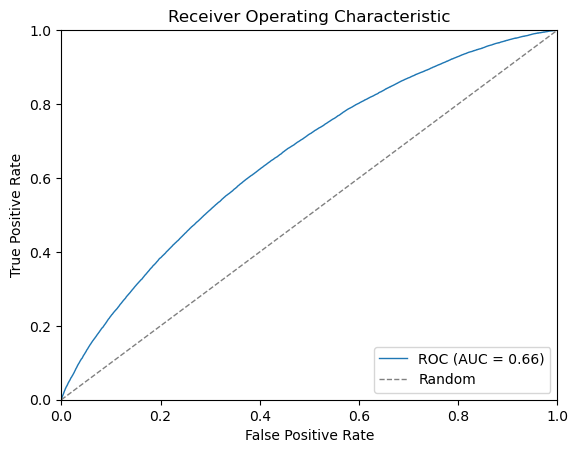

In [ ]:
# Generate ROC curve and AUC score for the validation set
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1, label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()